In [2]:
from particle import Particle 
import numpy as np 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt 
import itertools
from math import prod
from bs4 import BeautifulSoup

In [ ]:

with open('DECAY.XML', 'r') as f:
    data = f.read()
Bs_data = BeautifulSoup(data, "xml")
all_decays_unfiltered = Bs_data.find_all('decay')

In [7]:
particles_in_evtgen=[x['name'] for x in all_decays_unfiltered]
all_ids=[]
all_decays=[]
for p in all_decays_unfiltered:
    try:
        all_ids.append(Particle.from_evtgen_name(p['name']).pdgid)
    except:
        None
    else:
        all_decays.append(p)

len(all_decays)

250

In [8]:
def get_decays(pdgid: int):
    assert isinstance(pdgid, int), 'Input of get_decays must be a pdgid in integer form'
    try:
        decay=all_decays[all_ids.index(pdgid)]
        channels=decay.find_all('channel')
    except ValueError:
        channels=[]
    br=[]
    all_daughters=[]
    total_br=0
    for channel in channels:
        branching_ratio=float(channel['br'])
        if branching_ratio>0.01: 
            total_br+=branching_ratio
            br.append(branching_ratio)
            daughters=[int(Particle.from_evtgen_name(x).pdgid) for x in channel['daughters'].split()]
            all_daughters.append(daughters)
    if not all_daughters: return None,None
    else: return [x/total_br for x in br],all_daughters

get_decays(221)

([0.3961902842168918,
  0.3282604313646442,
  0.22918766377746422,
  0.0463616206409998],
 [[22, 22], [111, 111, 111], [-211, 211, 111], [22, -211, 211]])

In [9]:
def check_meson_combinations(m1,m2,m):
    valid=True
    if m1.mass+m2.mass > m: valid=False                                                         #check mass
    if (m1.charge!=0 or m2.charge!=0) and m1.pdgid!=(-1)*m2.pdgid: valid=False                #check if particle-antiparticle pair for charged mesons
    if (m1.charge==0 and m2.charge==0):        
        if m1.C!=m2.C: valid=False                                                         #check charge conjugation eigenvalue
        if m1.J==0 and m2.J==0 and m1.P!=m2.P: valid=False
        if ((m1.J==1 and m2.J==0) or (m1.J==0 and m2.J==1)) and m1.P!=(-1)*m2.P: valid=False    #parity must be opposite for l=1
        if ((m1.J==2 and m2.J==0) or (m1.J==0 and m2.J==2)) and m1.P!=m2.P: valid=False         #parity must be same for l=2
    if m1.I!=m2.I: valid=False                                                                  #isospin conservation
    if ((m1.pdgid.has_up and not m2.pdgid.has_up) or (m1.pdgid.has_down and not m2.pdgid.has_down) or
        (m1.pdgid.has_strange and not m2.pdgid.has_strange) or (m1.pdgid.has_charm and not m2.pdgid.has_charm) or 
        (m1.pdgid.has_bottom and not m2.pdgid.has_bottom)): valid=False
    return valid

def makeMesonPairs(cluster_mass,return_pdgid=True):
    mesons_below_threshold=Particle.findall(lambda p: p.mass<cluster_mass and p.pdgid.is_meson==True)
    if not mesons_below_threshold: print('No possible decay products. Maybe mass is too small?')
    #baryons_below_threshold=Particle.findall(lambda p: p.mass<cluster_mass and p.pdgid.is_baryon==True)
    meson_pairs=[]
    for i,m1 in enumerate(mesons_below_threshold):
        for m2 in mesons_below_threshold[i:]:
            if check_meson_combinations(m1,m2,cluster_mass):
                if return_pdgid: meson_pairs.append((int(m1.pdgid),int(m2.pdgid)))
                else: meson_pairs.append((m1,m2))
    return meson_pairs

from collections import Counter
#takes list of meson pdgids and returns all possible decay products with branching ratios
def decaymesons(mesons):
    all_brs=[]
    all_daughters=[]
    for meson in mesons:
        br,daughters=get_decays(meson)
        if daughters is not None:
            all_daughters.append(daughters)
            all_brs.append(br)
        else:
            all_daughters.append([[meson]])
            all_brs.append([1])
    all_combinations=[tuple(sorted(list(itertools.chain(*x)))) for x in itertools.product(*all_daughters)] #cartesian product to get all combinations
    br_combinations=[prod(x) for x in itertools.product(*all_brs)]
    all_decays=dict.fromkeys(all_combinations,0)
    for s,b in zip(all_combinations,br_combinations):
        all_decays[s]+=b
    if len(all_decays)==1 and next(iter(all_decays))==mesons: return None
    else:
        br_sum=np.sum([x for x in all_decays.values()])
        assert abs(1-br_sum)<1e-3, f'Branching ratios only add up to {br_sum} for state {mesons} with decays {all_decays}'
        return all_decays

def makeinitialWeights(meson_pairs,cluster_mass,spin_supression_par=1,up_weight=1,down_weight=1,strange_weight=1,charm_weight=1,bottom_weight=1):
    weights=np.zeros(len(meson_pairs))
    for i,pair in enumerate(meson_pairs):
        m1=pair[0]
        m2=pair[1]
        p_restframe=np.sqrt((cluster_mass**2-(m1.mass+m2.mass)**2)*(cluster_mass**2-(m1.mass-m2.mass)**2))/2/cluster_mass

        #spin multiplicity
        if m1.J==m2.J: spin_factor=(2*m1.J+1)*spin_supression_par
        else: spin_factor=(2*m1.J+1)*(2*m2.J+1)

        #quark weights
        quark_weight=1
        if m1.pdgid.has_up: quark_weight*=up_weight
        if m1.pdgid.has_down: quark_weight*=down_weight
        if m1.pdgid.has_strange: quark_weight*=strange_weight
        if m1.pdgid.has_charm: quark_weight*=charm_weight
        if m1.pdgid.has_bottom: quark_weight*=bottom_weight


        weights[i]=p_restframe*quark_weight*spin_factor
    return weights/np.sum(weights)
    #return np.ones(len(meson_pairs))/len(meson_pairs)

import networkx as nx 
def simulateDecay(cluster_mass,decay_graph=None,initial_states=None):
    if decay_graph is None:
        decay_graph=nx.DiGraph()
        initial_states=makeMesonPairs(cluster_mass)
        decay_graph.add_nodes_from(initial_states)
    all_decays_finished=True
    states_to_decay= [s for s,d in decay_graph.out_degree() if d==0]
    for state in states_to_decay:
        decays_of_this_state=decaymesons(state)
        if decays_of_this_state is not None: 
            edges=[(state,x,y) for x,y in decays_of_this_state.items()]
            for edge in edges:
                assert not edge in decay_graph.edges().data('weight'), f'Edge {edge} is overwritten'
            decay_graph.add_weighted_edges_from(edges)
            all_decays_finished=False

    if not all_decays_finished: decay_graph,initial_states=simulateDecay(cluster_mass,decay_graph,initial_states)
    return decay_graph,initial_states




In [10]:
decay_graph,initial_states=simulateDecay(2000)

In [11]:
def buildWeights(decay_graph,cluster_mass,initial_states):
    nx.set_node_attributes(decay_graph,0,name='weight')
    initial_states=makeMesonPairs(cluster_mass,return_pdgid=False)
    init_weights=makeinitialWeights(initial_states,cluster_mass)
    for s,w in zip(initial_states,init_weights):
        decay_graph.nodes[s]['weight']=w
    has_weight=[]
    while len(has_weight)!=len(decay_graph.nodes):
        for node in decay_graph.nodes:
            in_edges=decay_graph.in_edges(node,'weight')
            in_weights=[decay_graph.nodes[x[0]]['weight'] for x in in_edges]
            if not 0 in in_weights and not node in has_weight:
                for edge in in_edges:
                    decay_graph.nodes[node]['weight']+=decay_graph.nodes[edge[0]]['weight']*edge[2]
                has_weight.append(node)
    return decay_graph
weighted_graph=buildWeights(decay_graph,2000,initial_states)
print(weighted_graph)

DiGraph with 1053 nodes and 2769 edges


In [8]:
def brs_consistency_check(decay_graph):
    for node in decay_graph.nodes:
        decays=decaymesons(node)
        br=0
        out_edges=decay_graph.out_edges(node,'weight')
        for edge in out_edges:
            br+=edge[2]
        for d in out_edges:
            assert d[1] in decays.keys(), f'Decay {d} is missing from outgoing edges for node {node}.\n Decays: {decays} \n outgoing edges: {out_edges}'
        if out_edges: assert br>0.99, f'Branching ratio of state {node} is only {br}, with edges {out_edges}'

def weight_consistency_check(decay_graph,initial_states):
    for node in decay_graph.nodes:
        w=0
        edges=decay_graph.in_edges(node,'weight')
        for edge in edges:
            w+=decay_graph.nodes[edge[0]]['weight']*edge[2]
        if node in initial_states: w+=1/len(initial_states)
        weight=decay_graph.nodes[node]['weight'] 
        assert abs(weight-w)<1e-5,f'Wrong weight of node {node}: Is {weight}, should be {w}'
    assert not 0 in [v for u,v in decay_graph.nodes.data('weight')]

def total_brs_consistency_check(decay_graph):
    final_states,brs=get_final_states(decay_graph)
    assert abs(np.sum(brs)-1)<1e-5

weight_consistency_check(weighted_graph,initial_states)
brs_consistency_check(weighted_graph)
total_brs_consistency_check(weighted_graph)

AssertionError: Wrong weight of node (111, 111): Is 0.01651032436232279, should be 0.016129032258064516

In [9]:
def get_final_states(decay_graph):
    final_states= [s for s,d in decay_graph.out_degree() if d==0]
    attributes=nx.get_node_attributes(decay_graph,'weight')
    return {f:attributes[f] for f in final_states}

def most_common_final_states(decay_graph):
    final_states=get_final_states(decay_graph)
    return {k: v for k, v in sorted(final_states.items(), key=lambda item: item[1],reverse=True)}
    
final_states=get_final_states(weighted_graph)
sorted_final_states=most_common_final_states(weighted_graph)
for k in sorted_final_states.items():
    print(k)

((-211, 22, 22, 22, 22, 211), 0.08194914577891158)
((-211, -211, 22, 22, 22, 22, 211, 211), 0.0530388472820452)
((-211, -211, 211, 211), 0.051721678234780015)
((-211, 130, 211), 0.04508019499808974)
((-211, 22, 22, 130, 321), 0.04331288479171047)
((-321, 22, 22, 130, 211), 0.04331288479171047)
((-211, -211, 130, 211, 211), 0.04279590930963165)
((130, 130), 0.03974664730239598)
((-211, 130, 130, 211), 0.030872144469904227)
((-211, -211, 22, 22, 211, 321), 0.0300208217037136)
((-321, -211, 22, 22, 211, 211), 0.0300208217037136)
((-211, 22, 22, 22, 22, 130, 211), 0.028593300157240677)
((-211, 211, 9000221), 0.0239128210643324)
((22, 22, 10115), 0.022687288703577627)
((22, 22, 22, 22, 130), 0.019493922509122307)
((22, 22, 22, 22), 0.0183154314320326)
((-211, 211), 0.016499716701140747)
((-211, 321, 9000311), 0.016418871976381685)
((-9000311, -211, 321), 0.016418871976381685)
((-321, 211, 9000311), 0.016418871976381685)
((-9000311, -321, 211), 0.016418871976381685)
((-211, -211, -211, 211, 

In [10]:
def get_latex_id(list_of_ids):
    if not list_of_ids: return 'none'
    else:
        count=sorted(Counter(list_of_ids).items(),key=lambda x: np.abs(x[0]),reverse=True)
        vid=r'$'
        for x in count:
            if x[1]>1:
                vid+=str(x[1])
            vid+=Particle.from_pdgid(x[0]).latex_name
        return vid+'$'

{(-211, 22, 22, 22, 22, 211): array([-0.35606061,  0.        ]), (-211, 111, 111, 211): array([-0.17424242, -0.36363636]), (-211, 22, 22, 111, 211): array([-0.17424242, -0.18181818]), (-211, 22, 22, 211, 221): array([-0.17424242,  0.        ]), (111, 111, 310): array([-0.17424242,  0.18181818]), (-211, 211, 221, 221): array([-0.17424242,  0.36363636]), (213, -213): array([ 0.00757576, -1.        ]), (310, 310): array([ 0.00757576, -0.81818182]), (9010221, 9010221): array([ 0.00757576, -0.63636364]), (-211, 211, 310): array([ 0.00757576, -0.45454545]), (221, 221): array([ 0.00757576, -0.27272727]), (-213, 22, 22, 211): array([ 0.00757576, -0.09090909]), (-211, 22, 22, 213): array([0.00757576, 0.09090909]), (221, 20223): array([0.00757576, 0.27272727]), (331, 331): array([0.00757576, 0.45454545]), (-211, 22, 22, 9000211): array([0.00757576, 0.63636364]), (-9000211, 22, 22, 211): array([0.00757576, 0.81818182]), (9000211, -9000211): array([0.00757576, 1.        ]), (311, 311): array([ 0.1

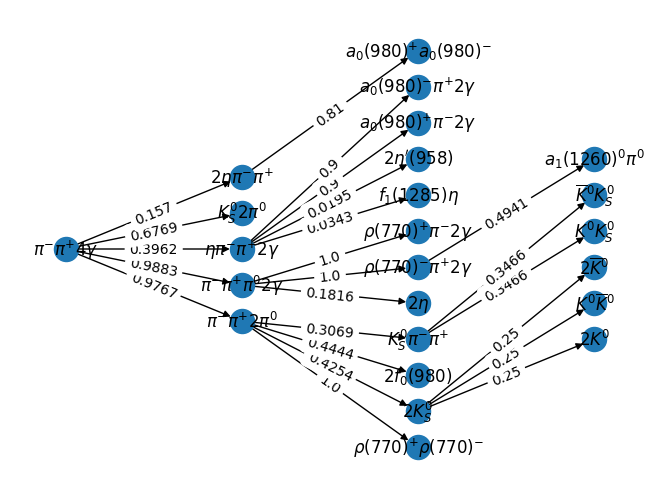

In [58]:
def plot_from_initial_state(decay_graph,state):
    round_val=4
    edge_data = { (u,v) : d for u, v, d in decay_graph.edges.data() }  
    node_data = { u : d for u, d in decay_graph.nodes.data() }  
    sub = nx.dfs_tree(decay_graph,state)
    nx.set_edge_attributes(sub, edge_data)
    nx.set_node_attributes(sub,node_data)
    pos=nx.bfs_layout(sub,state)
    edge_labels = {key:round(val,round_val) for key,val in nx.get_edge_attributes(sub,'weight').items()}

    nx.draw(sub,with_labels=False,pos=pos)
    nx.draw_networkx_edge_labels(sub,pos,edge_labels=edge_labels)
    plt.show()

def plot_from_final_state(decay_graph,state):
    round_val=4
    decay_graph=decay_graph.reverse()
    edge_data = { (u,v) : d for u, v, d in decay_graph.edges.data() }  
    node_data = { u : d for u, d in decay_graph.nodes.data() }  
    sub = nx.dfs_tree(decay_graph,state)
    nx.set_edge_attributes(sub, edge_data)
    nx.set_node_attributes(sub,node_data)
    pos=nx.bfs_layout(sub,state)
    print(pos)
    edge_labels = {key:round(val,round_val) for key,val in nx.get_edge_attributes(sub,'weight').items()}
    #node_labels = {key:get_latex_id(key)+'\n'+str(round(val,round_val)) for key,val in nx.get_node_attributes(sub,'weight').items()}
    node_labels = {key:get_latex_id(key) for key,val in nx.get_node_attributes(sub,'weight').items()}
    x_pos=set([val[0] for val in pos.values()])
    print(node_labels.values())
    """
    f = plt.figure()
    r = f.canvas.get_renderer()
    widths={}
    for x in x_pos:
        label_widths={}
        for label in node_labels:
            if pos[label][0]==x:
                t = plt.text(0.5, 0.5, label)
                bb = t.get_window_extent(renderer=r)
                width = bb.width
                height = bb.height
                label_widths[label]=width
        max_width=max(label_widths.values())
        print(max_width)
        widths[x]=max_width
    tot_width=0
    for v in widths.values(): tot_width+=v
    for w in widths: widths[w]=widths[w]/tot_width
    print(widths)
    for x in x_pos:
        for label in pos:
            if pos[label][0]==x: pos[label][1]*=widths[x]

        #key_lens=[len(key) for key in node_labels if node_labels[key][0]==x]


    print(x_pos)
    """
    nx.draw(sub,with_labels=False,pos=pos)#,verticalalignment='bottom') #node_size=[len(node_labels[i])**2 * 20 for i in pos],node_color='white')
    nx.draw_networkx_edge_labels(sub,pos,edge_labels=edge_labels)
    nx.draw_networkx_labels(sub,pos,labels=node_labels)
    plt.show()

final_states=list(get_final_states(decay_graph).keys())
plot_from_final_state(weighted_graph,(-211,22,22,22,22,211))

In [16]:
import pdg
api=pdg.connect()

In [17]:
def print_decays(pdgid):
    for bf in api.get_particle_by_mcid(pdgid).exclusive_branching_fractions(include_subdecays=False):
        if not bf.value is None and bf.value>0.01:
            print('%-60s    %s' % (bf.description, bf.value))

def print_decays_by_name(name):
    for bf in api.get_particle_by_name(name).exclusive_branching_fractions(include_subdecays=False):
        if not bf.value is None and bf.value>0.01:
            print('%-60s    %s' % (bf.description, bf.value))


In [18]:
print_decays_by_name('pi+')

pi+ --> mu+ nu_mu                                               0.999877


In [81]:
get_decays(521)

([0.08695568812862897,
  0.03500692351427951,
  0.08695568812862897,
  0.03500692351427951,
  0.03056438950039683,
  0.02613255302283929,
  0.020478140965265876,
  0.029036170025376985,
  0.02292329212529762,
  0.018338633700238097,
  0.04977770267360148,
  0.32392183088309756,
  0.061831949458517686,
  0.033939362876712266,
  0.11162280093248222,
  0.02750795055035714],
 [[-423, -11, 12],
  [-421, -11, 12],
  [-423, -13, 14],
  [-421, -13, 14],
  [-423, -15, 16],
  [433, -423],
  [213, -421],
  [-423, 20213],
  [-413, 111, 211, 211],
  [-423, 20433],
  [-4103, 2203],
  [2, -1, -4, 2],
  [2, -1, -4, 2],
  [2, -3, -4, 2],
  [4, -3, -4, 2],
  [-423, -211, 211, 211, 111]])

In [34]:
api.get_particle_by_name('B+').mcid

521

In [82]:
class ScalarHadronizer_using_api():
    def get_particle_decays(self,name):
        decays={}
        total_br=0
        for bf in api.get_particle_by_name(name).exclusive_branching_fractions():
            names=tuple([p.item.name for p in bf.decay_products])
            if not bf.value is None and bf.value>=0.01:
                decays[names]=bf.value
                total_br+=bf.value
        #for d in decays:
        #    decays[d]*=1/total_br
        return decays


In [80]:
SH=ScalarHadronizer()
SH.get_particle_decays('B+')

{('Dbar0', 'rho+'): 0.0134483048472962,
 ('Dbar^*(2007)0', 'pi+', 'pi+', 'pi-'): 0.010302962962963,
 ('Dbar^*(2007)0', 'pi-', 'pi+', 'pi+', 'pi0'): 0.018,
 ('D^*(2010)-', 'pi+', 'pi+', 'pi0'): 0.0151577059953006,
 ('D_sJ(2457)+', 'Dbar^*(2007)0'): 0.0119604744343514,
 ('D-', 'D_s()+', 'pi+'): 0.0559078385442635,
 ('Dbar^*(2007)0', 'D_s^*()+'): 0.0170630059650859,
 ('-->',
  'D-',
  'pi+',
  'Dbar_2^*(2460)0',
  'D_s()+',
  ',',
  'Dbar_2^*'): 0.0124954019146429,
 ('D_s^(*)()+', 'Dbar^**()0'): 0.0273,
 ('Dbar0', 'D^*(2010)+', '+', 'Dbar^*(2007)0', 'D+'): 0.013,
 ('Dbar^*(2007)0', 'D^*(2007)0', 'K+'): 0.01123,
 ('( Dbar + Dbar^* )( D + D^* ) K',): 0.0405,
 ('Lambdabar_c()-', 'p', 'pi+', 'pi+', 'pi-', 'pi0'): 0.0134}

In [103]:
from particle import Particle 
import numpy as np 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt 
import itertools
from math import prod
from bs4 import BeautifulSoup
from collections import Counter
import networkx as nx 

class ScalarHadronizer:
    def __init__(self,path_to_decayXML='DECAY.XML'):
        self.all_decaysXML=self.read_decayXML(path_to_decayXML)

    def read_decayXML(self,path_to_decayXML):
        with open(path_to_decayXML, 'r') as f:
            data = f.read()
        Bs_data = BeautifulSoup(data, "xml")
        decayXMLtree = Bs_data.find_all('decay')

        particles_in_evtgen=[x['name'] for x in decayXMLtree]
        all_decaysXML={}
        #append only those with valid monte carlo id
        for p in decayXMLtree:
            try:
                pdgid=Particle.from_evtgen_name(p['name']).pdgid
                all_decaysXML[pdgid]=p
            except:
                None
        return all_decaysXML

    def single_particle_decays(self,pdgid: int):
        assert isinstance(pdgid, int), 'Input of get_decays must be a pdgid in integer form'
        try:
            decay=self.all_decaysXML[pdgid]
            channels=decay.find_all('channel')
        except KeyError:
            channels=[]
        total_br=0
        branching_ratios={}
        for channel in channels:
            branching_ratio=float(channel['br'])
            if branching_ratio>0.01: 
                daughters=tuple([int(Particle.from_evtgen_name(x).pdgid) for x in channel['daughters'].split()])
                branching_ratios[daughters]=branching_ratio
                total_br+=branching_ratio
        branching_ratios={d:b/total_br for d,b in branching_ratios.items()}
        return branching_ratios
    
    def check_meson_combinations(self,m1,m2,m):
        valid=True
        if m1.mass+m2.mass > m: valid=False                                                         #check mass
        if (m1.charge!=0 or m2.charge!=0) and m1.pdgid!=(-1)*m2.pdgid: valid=False                #check if particle-antiparticle pair for charged mesons
        if (m1.charge==0 and m2.charge==0):        
            if m1.C!=m2.C: valid=False                                                         #check charge conjugation eigenvalue
            if m1.J==0 and m2.J==0 and m1.P!=m2.P: valid=False
            if ((m1.J==1 and m2.J==0) or (m1.J==0 and m2.J==1)) and m1.P!=(-1)*m2.P: valid=False    #parity must be opposite for l=1
            if ((m1.J==2 and m2.J==0) or (m1.J==0 and m2.J==2)) and m1.P!=m2.P: valid=False         #parity must be same for l=2
        if m1.I!=m2.I: valid=False                                                                  #isospin conservation
        if ((m1.pdgid.has_up and not m2.pdgid.has_up) or (m1.pdgid.has_down and not m2.pdgid.has_down) or
            (m1.pdgid.has_strange and not m2.pdgid.has_strange) or (m1.pdgid.has_charm and not m2.pdgid.has_charm) or 
            (m1.pdgid.has_bottom and not m2.pdgid.has_bottom)): valid=False
        return valid

    #make list of initial meson pairs based on selection rules
    #if return_only_idgid only the ids of the particles is returned. Else a particle object is returned
    def make_initialMesonPairs(self,scalar_mass,return_only_pdgid=True):
        mesons_below_threshold=Particle.findall(lambda p: p.mass<scalar_mass and p.pdgid.is_meson==True)
        if not mesons_below_threshold: print('No possible decay products. Maybe mass is too small?')
        #baryons_below_threshold=Particle.findall(lambda p: p.mass<scalar_mass and p.pdgid.is_baryon==True)
        meson_pairs=[]
        for i,m1 in enumerate(mesons_below_threshold):
            for m2 in mesons_below_threshold[i:]:
                if self.check_meson_combinations(m1,m2,scalar_mass):
                    if return_only_pdgid: meson_pairs.append((int(m1.pdgid),int(m2.pdgid)))
                    else: meson_pairs.append((m1,m2))
        return meson_pairs

    def all_decays_of_multiparticle_state(self,mesons):
        all_brs=[]
        all_daughters=[]
        for meson in mesons:
            decays_of_this_meson=self.single_particle_decays(meson)
            if decays_of_this_meson:
                all_daughters.append(list(decays_of_this_meson.keys()))
                all_brs.append(list(decays_of_this_meson.values()))
            else:
                all_daughters.append([[meson]])
                all_brs.append([1])
        all_combinations=[tuple(sorted(list(itertools.chain(*x)))) for x in itertools.product(*all_daughters)] #cartesian product to get all combinations
        br_combinations=[prod(x) for x in itertools.product(*all_brs)]
        all_decays=dict.fromkeys(all_combinations,0)
        for s,b in zip(all_combinations,br_combinations):
            all_decays[s]+=b
        if len(all_decays)==1 and next(iter(all_decays))==mesons: return None
        else:
            br_too_small=[]
            for k,v in all_decays.items():
                if v<1e-2: br_too_small.append(k)
            br_sum=np.sum([v for k,v in all_decays.items() if k not in br_too_small])
            all_decays={k:v/br_sum for k,v in all_decays.items() if k not in br_too_small}
            return all_decays

    def build_decay_graph(self,scalar_mass,decay_graph=None):
        if decay_graph is None:
            decay_graph=nx.DiGraph()
            initial_states=self.make_initialMesonPairs(scalar_mass)
            decay_graph.add_nodes_from(initial_states)
            print(f'Generated {len(initial_states)} initial meson pairs.')
        all_decays_finished=True
        states_to_decay= [s for s,d in decay_graph.out_degree() if d==0]
        for state in states_to_decay:
            decays_of_this_state=self.all_decays_of_multiparticle_state(state)
            if decays_of_this_state is not None: 
                edges=[(state,x,y) for x,y in decays_of_this_state.items()]
                #for edge in edges:
                #    assert not edge in decay_graph.edges().data('weight'), f'Edge {edge} is overwritten'
                decay_graph.add_weighted_edges_from(edges)
                all_decays_finished=False

        if not all_decays_finished: decay_graph=self.build_decay_graph(scalar_mass,decay_graph)
        return decay_graph

    def buildWeights(self,decay_graph,scalar_mass):
        nx.set_node_attributes(decay_graph,0,name='weight')
        initial_states=self.make_initialMesonPairs(scalar_mass,return_only_pdgid=False)
        init_weights=self.initialWeights(initial_states,scalar_mass)
        nodes=decay_graph.nodes
        for s,w in zip(initial_states,init_weights):
            nodes[s]['weight']=w
        has_weight=[]
        while len(has_weight)!=len(nodes):
            for node in nodes:
                in_edges=decay_graph.in_edges(node,'weight')
                in_weights=[nodes[x[0]]['weight'] for x in in_edges]
                if not 0 in in_weights and not node in has_weight:
                    for edge in in_edges:
                        nodes[node]['weight']+=nodes[edge[0]]['weight']*edge[2]
                    has_weight.append(node)
        return decay_graph

    def initialWeights(self,meson_pairs,scalar_mass,spin_supression_par=1,up_weight=1,down_weight=1,strange_weight=1,charm_weight=1,bottom_weight=1):
        weights=np.zeros(len(meson_pairs))
        for i,pair in enumerate(meson_pairs):
            m1=pair[0]
            m2=pair[1]
            p_restframe=np.sqrt((scalar_mass**2-(m1.mass+m2.mass)**2)*(scalar_mass**2-(m1.mass-m2.mass)**2))/2/scalar_mass

            #spin multiplicity
            if m1.J==m2.J: spin_factor=(2*m1.J+1)*spin_supression_par
            else: spin_factor=(2*m1.J+1)*(2*m2.J+1)

            #quark weights
            quark_weight=1
            if m1.pdgid.has_up: quark_weight*=up_weight
            if m1.pdgid.has_down: quark_weight*=down_weight
            if m1.pdgid.has_strange: quark_weight*=strange_weight
            if m1.pdgid.has_charm: quark_weight*=charm_weight
            if m1.pdgid.has_bottom: quark_weight*=bottom_weight


            weights[i]=p_restframe*quark_weight*spin_factor
        return weights/np.sum(weights)
        #return np.ones(len(meson_pairs))/len(meson_pairs)

    def simulateDecay(self,scalar_mass):
        print('Building decay graph...')
        decay_graph=self.build_decay_graph(scalar_mass)
        print(f'Generated decay graph with {decay_graph.number_of_nodes()} nodes and {decay_graph.number_of_edges()} edges.')
        print('Building weights...')
        weighted_graph=self.buildWeights(decay_graph,scalar_mass)
        print('Done')
        return weighted_graph

    def get_final_states(self,decay_graph):
        final_states= [s for s,d in decay_graph.out_degree() if d==0]
        attributes=nx.get_node_attributes(decay_graph,'weight')
        return {f:attributes[f] for f in final_states}

    def get_most_common_final_states(self,decay_graph):
        final_states=self.get_final_states(decay_graph)
        return {k: v for k, v in sorted(final_states.items(), key=lambda item: item[1],reverse=True)}

    def get_latex_id(self,list_of_ids):
        if not list_of_ids: return 'none'
        else:
            count=sorted(Counter(list_of_ids).items(),key=lambda x: np.abs(x[0]),reverse=True)
            vid=r'$'
            for x in count:
                if x[1]>1:
                    vid+=str(x[1])
                vid+=Particle.from_pdgid(x[0]).latex_name
            return vid+'$'

    def plot_from_initial_state(self,decay_graph,state):
        round_val=4
        edge_data = { (u,v) : d for u, v, d in decay_graph.edges.data() }  
        node_data = { u : d for u, d in decay_graph.nodes.data() }  
        sub = nx.dfs_tree(decay_graph,state)
        nx.set_edge_attributes(sub, edge_data)
        nx.set_node_attributes(sub,node_data)
        pos=nx.bfs_layout(sub,state)
        edge_labels = {key:round(val,round_val) for key,val in nx.get_edge_attributes(sub,'weight').items()}

        nx.draw(sub,with_labels=False,pos=pos)
        nx.draw_networkx_edge_labels(sub,pos,edge_labels=edge_labels)
        plt.show()

    def plot_from_final_state(self,decay_graph,state):
        round_val=4
        decay_graph=decay_graph.reverse()
        edge_data = { (u,v) : d for u, v, d in decay_graph.edges.data() }  
        node_data = { u : d for u, d in decay_graph.nodes.data() }  
        sub = nx.dfs_tree(decay_graph,state)
        nx.set_edge_attributes(sub, edge_data)
        nx.set_node_attributes(sub,node_data)
        sub=sub.reverse()
        pos=nx.bfs_layout(sub,state)
        print(pos)
        edge_labels = {key:round(val,round_val) for key,val in nx.get_edge_attributes(sub,'weight').items()}
        #node_labels = {key:get_latex_id(key)+'\n'+str(round(val,round_val)) for key,val in nx.get_node_attributes(sub,'weight').items()}
        node_labels = {key:self.get_latex_id(key) for key,val in nx.get_node_attributes(sub,'weight').items()}
        x_pos=set([val[0] for val in pos.values()])
        print(node_labels.values())
        """
        f = plt.figure()
        r = f.canvas.get_renderer()
        widths={}
        for x in x_pos:
            label_widths={}
            for label in node_labels:
                if pos[label][0]==x:
                    t = plt.text(0.5, 0.5, label)
                    bb = t.get_window_extent(renderer=r)
                    width = bb.width
                    height = bb.height
                    label_widths[label]=width
            max_width=max(label_widths.values())
            print(max_width)
            widths[x]=max_width
        tot_width=0
        for v in widths.values(): tot_width+=v
        for w in widths: widths[w]=widths[w]/tot_width
        print(widths)
        for x in x_pos:
            for label in pos:
                if pos[label][0]==x: pos[label][1]*=widths[x]

            #key_lens=[len(key) for key in node_labels if node_labels[key][0]==x]


        print(x_pos)
        """
        nx.draw(sub,with_labels=False,pos=pos)#,verticalalignment='bottom') #node_size=[len(node_labels[i])**2 * 20 for i in pos],node_color='white')
        nx.draw_networkx_edge_labels(sub,pos,edge_labels=edge_labels)
        nx.draw_networkx_labels(sub,pos,labels=node_labels)
        plt.show()
    




In [ ]:

def brs_consistency_check(hadronizer,decay_graph,scalar_mass):
    for node in decay_graph.nodes:
        decays=hadronizer.all_decays_of_multiparticle_state(node)
        br=0
        out_edges=decay_graph.out_edges(node,'weight')
        for edge in out_edges:
            br+=edge[2]
        for d in out_edges:
            assert d[1] in decays.keys(), f'Decay {d} is missing from outgoing edges for node {node}.\n Decays: {decays} \n outgoing edges: {out_edges}'
        if out_edges: assert br>0.99, f'Branching ratio of state {node} is only {br}, with edges {out_edges}'

def weight_consistency_check(hadronizer,decay_graph,scalar_mass):
    initial_states_ids=hadronizer.make_initialMesonPairs(scalar_mass)
    initial_states_particles=hadronizer.make_initialMesonPairs(scalar_mass,return_only_pdgid=False)
    initial_weights=hadronizer.initialWeights(initial_states_particles,scalar_mass)
    for node in decay_graph.nodes:
        w=0
        edges=decay_graph.in_edges(node,'weight')
        for edge in edges:
            w+=decay_graph.nodes[edge[0]]['weight']*edge[2]
        if node in initial_states_ids: w+=initial_weights[initial_states_ids.index(node)]
        weight=decay_graph.nodes[node]['weight']
        assert abs(weight-w)<1e-5,f'Wrong weight of node {node}: Is {weight}, should be {w}'
    assert not 0 in [v for u,v in decay_graph.nodes.data('weight')]

def total_brs_consistency_check(hadronizer,decay_graph):
    final_states=hadronizer.get_final_states(decay_graph)
    assert abs(np.sum(list(final_states.values()))-1)<1e-5

SH=ScalarHadronizer()
mass=3000
decay_graph=SH.simulateDecay(mass)
brs_consistency_check(SH,decay_graph,mass)
weight_consistency_check(SH,decay_graph,mass)
total_brs_consistency_check(SH,decay_graph)

Building decay graph...
Generated 62 initial meson pairs.
Generated decay graph with 623 nodes and 1200 edges.
Building weights...
Done


In [ ]:
SH=ScalarHadronizer()
decay_graph=SH.simulateDecay(2000)

{(-211, 22, 22, 22, 22, 211): np.float64(0.08195684407184274), (-211, -211, 22, 22, 22, 22, 211, 211): np.float64(0.053038132367269945), (-211, -211, 211, 211): np.float64(0.05172072137561507), (-211, 130, 211): np.float64(0.04507936100740703), (-321, 22, 22, 130, 211): np.float64(0.04331211682276842), (-211, 22, 22, 130, 321): np.float64(0.043312116822768414), (-211, -211, 130, 211, 211): np.float64(0.042795117578592695), (130, 130): np.float64(0.03974591198318273), (-211, 130, 130, 211): np.float64(0.030871573330386214), (-211, -211, 22, 22, 211, 321): np.float64(0.030020289412715354), (-321, -211, 22, 22, 211, 211): np.float64(0.03002028941271535), (-211, 22, 22, 22, 22, 130, 211): np.float64(0.028592778987791837), (-211, 211, 9000221): np.float64(0.023912378673389648), (22, 22, 10115): np.float64(0.02268686898517589), (22, 22, 22, 22, 130): np.float64(0.01949356186849636), (22, 22, 22, 22): np.float64(0.018315092593676544), (-211, 211): np.float64(0.016499411453792183), (-211, 321,

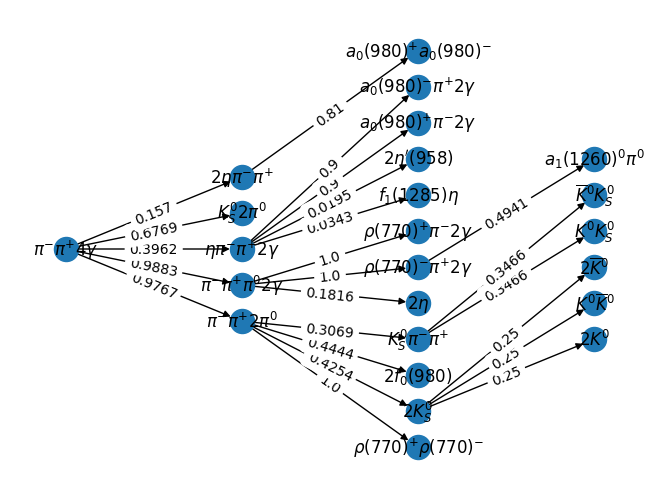

In [78]:
fs=SH.get_most_common_final_states(decay_graph)
print(fs)
SH.plot_from_final_state(decay_graph,(-211,22,22,22,22,211))